In [27]:
import json
from pathlib import Path
import pickle
import re
import time

import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
import pyrootutils

root = pyrootutils.setup_root(".", pythonpath=True)

from src.utils.data_util.baidu_translate_api import BaiDuFanyi

In [28]:
def clean_str_sst(string):
    """
    Tokenization/string cleaning for the SST dataset
    """
    string = re.sub(u"[，。 :,.；|-“”——_/nbsp+&;@、《》～（）())#O！：【】]", "", string)
    return string.strip().lower()

In [29]:
def clean_text(text):
    try:
        text = text.decode('utf-8').lower()
    except:
        text = text.encode('utf-8').decode('utf-8').lower()
    text = re.sub(u"\u2019|\u2018", "\'", text)
    text = re.sub(u"\u201c|\u201d", "\"", text)
    text = re.sub(u"[\u2000-\u206F]", " ", text)
    text = re.sub(u"[\u20A0-\u20CF]", " ", text)
    text = re.sub(u"[\u2100-\u214F]", " ", text)
    text = re.sub(r"http:\ ", "http:", text)
    text = re.sub(r"http[s]?:[^\ ]+", " ", text)
    text = re.sub(r"&gt;", " ", text)
    text = re.sub(r"&lt;", " ", text)
    text = re.sub(r"&quot;", " ", text)
    text = re.sub(r"\"", " ", text)
    text = re.sub(r"#\ ", "#", text)
    text = re.sub(r"\\n", " ", text)
    text = re.sub(r"\\", " ", text)
    text = re.sub(r"[\(\)\[\]\{\}]", r" ", text)
    text = re.sub(u'['
                  u'\U0001F300-\U0001F64F'
                  u'\U0001F680-\U0001F6FF'
                  u'\u2600-\u26FF\u2700-\u27BF]+',
                  r" ", text)
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " had ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"#", " #", text)
    text = re.sub(r"\@", " \@", text)
    text = re.sub(r"[\!\?\.\,\+\-\$\%\^\>\<\=\:\;\*\(\)\{\}\[\]\/\~\&\'\|]", " ", text)
    text = text.strip()
    text = " ".join(text.split())

    return text

In [30]:
dev_data = pd.read_csv(
    root / "data/image-verification-corpus-master/mediaeval2016/devset/posts.txt", 
    delimiter="\t",)

In [31]:
test_data = pd.read_csv(
    root / "data/image-verification-corpus-master/mediaeval2016/testset/posts_groundtruth.txt",
    delimiter="\t",)

In [32]:
dev_data["label"] = dev_data.label.apply(lambda x: 0 if x == "real" else 1)
test_data["label"] = test_data.label.apply(lambda x: 0 if x == "real" else 1)

In [33]:
dev_data["image_id(s)"]

0        boston_fake_03,boston_fake_35
1                       boston_fake_23
2                       boston_fake_34
3        boston_fake_03,boston_fake_35
4                       boston_fake_15
                     ...              
15624                     varoufakis_1
15625                     varoufakis_1
15626                     varoufakis_1
15627                     varoufakis_1
15628                     varoufakis_1
Name: image_id(s), Length: 15629, dtype: object

In [34]:
def refine_images(root_dir: Path, path: Path):
    if not root_dir.exists():
        root_dir.mkdir(parents=True)
    try:
        image = Image.open(str(path)).convert("RGB")
        if min(image.size) < 100:
            save_path = ""
        else:
            save_path = root_dir / (path.stem + path.suffix)
            # cv2.imwrite(str(save_path), image)
            with save_path.open("wb") as f:
                # pickle.dump(image, f)
                image.save(f)
    except Exception as e:
        tqdm.write(str(e))
        save_path = ""
    return str(save_path)

In [35]:
img_path_list = [
    root / "data/image-verification-corpus-master/mediaeval2015/devset/MediaEval2015_DevSet_Images",
    root / "data/image-verification-corpus-master/mediaeval2015/testset/MediaEval2015_TestSetImages",
    root / "data/image-verification-corpus-master/mediaeval2016/testset/Mediaeval2016_TestSet_Images/Mediaeval2016_TestSet_Images",
]

In [36]:
img_save_path = Path(root / "data/image-verification-corpus-master/images_filtered")
img_list = []
if not img_save_path.exists():
    img_save_path.mkdir(parents=True)

for img_path in img_path_list:
    img_path = Path(img_path)
    cnt = 0
    for f in tqdm(img_path.glob("*"), desc=f"Refining images in {str(img_path)}"):
        if f.suffix in [".txt"]:
            continue
        else:
            img = refine_images(img_save_path, f)
            if img:
                img_list.append(img)
                cnt += 1 
    print(f"===== Valid images in {str(img_path)}: {cnt} in total ======")

Refining images in /root/fake_news_detection/data/image-verification-corpus-master/mediaeval2015/devset/MediaEval2015_DevSet_Images: 570it [00:05, 95.50it/s] 


===== Valid images in /root/fake_news_detection/data/image-verification-corpus-master/mediaeval2015/devset/MediaEval2015_DevSet_Images: 570 in total ======


Refining images in /root/fake_news_detection/data/image-verification-corpus-master/mediaeval2015/testset/MediaEval2015_TestSetImages: 52it [00:00, 268.49it/s]


===== Valid images in /root/fake_news_detection/data/image-verification-corpus-master/mediaeval2015/testset/MediaEval2015_TestSetImages: 50 in total ======


Refining images in /root/fake_news_detection/data/image-verification-corpus-master/mediaeval2016/testset/Mediaeval2016_TestSet_Images/Mediaeval2016_TestSet_Images: 130it [00:00, 135.16it/s]

===== Valid images in /root/fake_news_detection/data/image-verification-corpus-master/mediaeval2016/testset/Mediaeval2016_TestSet_Images/Mediaeval2016_TestSet_Images: 104 in total ======


In [37]:
img_dict = {x.split("/")[-1].split(".")[0]: x for x in img_list}

In [38]:
img_dict["boston_fake_35"]

'/root/fake_news_detection/data/image-verification-corpus-master/images_filtered/boston_fake_35.jpg'

In [39]:
dev_data.head()

,post_id,post_text,user_id,image_id(s),username,timestamp,label
0,324597532548276224,Don't need feds to solve the #bostonbombing wh...,886672620,"boston_fake_03,boston_fake_35",SantaCruzShred,Wed Apr 17 18:57:37 +0000 2013,1
1,325145334739267584,PIC: Comparison of #Boston suspect Sunil Tripa...,21992286,boston_fake_23,Oscar_Wang,Fri Apr 19 07:14:23 +0000 2013,1
2,325152091423248385,I'm not completely convinced that it's this Su...,16428755,boston_fake_34,jamwil,Fri Apr 19 07:41:14 +0000 2013,1
3,324554646976868352,Brutal lo que se puede conseguir en colaboraci...,303138574,"boston_fake_03,boston_fake_35",rubenson80,Wed Apr 17 16:07:12 +0000 2013,1
4,324315545572896768,4chan and the bombing. just throwing it out th...,180460772,boston_fake_15,Slimlenny,Wed Apr 17 00:17:06 +0000 2013,1


<AxesSubplot: >

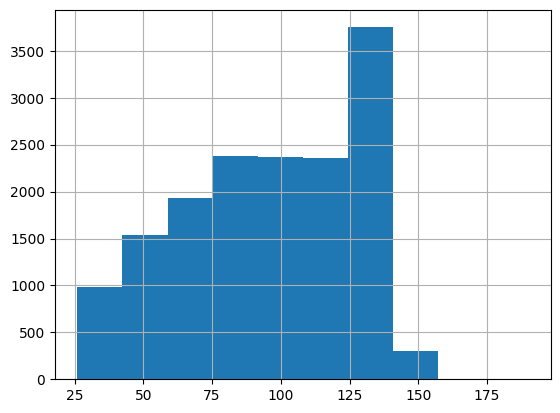

In [40]:
dev_data.post_text.apply(lambda x: len(x)).hist()

In [41]:
def check_valid_image(img_root_dir: Path, img_id_list: list):
    valid_img_list = []
    for img_id in img_id_list:
        img_id = img_id.strip()
        img_name = img_dict.get(img_id, "")
        if img_name:
            valid_img_list.append(img_name.split("/")[-1])
        else:
            print(f"{img_id} not exists")
    return valid_img_list

In [42]:
dev_data["imgs"] = dev_data["image_id(s)"].apply(lambda x: check_valid_image(img_save_path, x.split(",")))

boston_real_05 not exists
sandy_real_90 not exists
sandy_real_90 not exists
sandy_real_4 not exists
sandy_real_6 not exists
sandy_real_6 not exists
sandy_real_6 not exists
sandy_real_6 not exists
sandy_real_6 not exists
sandy_real_6 not exists
sandy_real_6 not exists
sandy_real_6 not exists
sandy_real_6 not exists
sandy_real_4 not exists
sandy_real_6 not exists
sandy_real_6 not exists
sandy_real_6 not exists
sandy_real_6 not exists
sandy_real_6 not exists
sandy_real_90 not exists
eclipse_video_01 not exists
eclipse_video_01 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists
syrianboy_1 not exists

In [43]:
# import pickle

# translated_train_data = pickle.load(open("/root/BDANN-IJCNN2020/Data/twitter/cleaned_train_text.pkl", "rb"))
# translated_test_data = pickle.load(open("/root/BDANN-IJCNN2020/Data/twitter/cleaned_test_text.pkl", "rb"))

In [45]:
# def trans_and_sleep(text):
#     result = translator.translate(text)
#     time.sleep(0.1)
#     return result

In [46]:
# trans_and_sleep("你好师姐")

In [47]:
dev_data["text"] = dev_data.post_text.apply(lambda x: clean_text(x))

In [48]:
# from collections import defaultdict

# dev_translated_text_list = []
# for row in dev_data.iterrows():
#     dev_translated_text_list.append({"post_id": row[1]["post_id"], "oringin_text": row[1]["text"]})

In [49]:
# from multiprocessing.dummy import Pool as ThreadPool

# pool = ThreadPool(4) # Threads

# def request(d: dict):
#     d["translated_text"] = translator.translate(d["oringin_text"])
    
# try:
#     pool.map(request, dev_translated_text_list)
# except Exception as e:
#     print(e)
# finally:
#     pool.close()
#     pool.join()

In [50]:
# dev_translated_text_list

In [51]:
dev_data_valid = dev_data[dev_data.imgs.apply(len) > 0]

In [52]:
test_data["imgs"] = test_data["image_id"].apply(lambda x: check_valid_image(img_save_path, x.split(",")))

airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
airstrikes_1 not exists
american_soldier_quran_1 not exists
american_soldier_quran_1 not exists
american_soldier_quran_1 not exists
american_soldier_quran_1 not exists
american_soldier_quran_1 not exists
american_soldier_quran_1 not exists
american_soldier_quran_1 not exists
american_soldier_quran_1 not exists
american_soldier_quran_1 not exists
american_soldier_quran_1 not exists
american_soldier_quran_1 not exists
american_soldier_quran_1 not

In [53]:
test_data["text"] = test_data.post_text.apply(lambda x: clean_text(x))

In [54]:
test_data_valid = test_data[test_data.imgs.apply(len) > 0]

In [55]:
dev_data_valid.to_json(root / "data/image-verification-corpus-master/train_posts.json", 
                       lines=True,
                       orient="records",
                       force_ascii=False)
test_data_valid.to_json(root / "data/image-verification-corpus-master/test_posts.json", 
                       lines=True,
                       orient="records",
                       force_ascii=False)


: 